# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sqlite3.connect('final.sqlite') 

#getting the dataset into a dataframe 
final = pd.read_sql_query("""
SELECT * FROM Reviews where ProfileName like "j%" order by Time
""", con) 

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(final.shape[0]*1.0)*100)

(37217, 12)


100.0

In [4]:
print(final.shape)

(37217, 12)


In [5]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
This product is a real bargain, considering the fact that dogs love liver. I've used this as an addition to another dog treat product I use for my dog. My dog goes nuts when he knows that he's about to be rewarded with<br />Pro-Treat Beef Liver treats. The instructions advise to give 2-3 pieces per day when using. At this rate, the container will last you a good while. The product itself is very fresh and the pieces are all of various sizes and thickness. Average size of treat is small rectangular pieces of different thickness. They're easy to break into smaller pieces if necessary. My Springer Spaniel pup is 5 months old and he just loves these. I tried this product on my girlfriend's 10 yr old teacup Poodle, who is pretty slow at this point in her life. She absolutely came to life and jumped all over the place for a taste of one of these treats. Buy it....your dog will love it!


In [7]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'below', 'now', 'mustn', "weren't", 'through', 'ours', "that'll", 's', 'were', "doesn't", 'here', 'other', 'where', "you'd", 'ourselves', 'doing', 'do', 'being', 'can', 'on', 'there', 'does', 'our', 'yourself', 've', 'from', 'because', 'yourselves', 'further', 'same', 'and', 'how', 'myself', 'why', 'haven', 'these', "mustn't", 'didn', 'each', 'him', 'you', 'with', 'only', 'don', 'which', 're', 'in', 'above', 'if', "isn't", "aren't", "you're", 'then', 'his', 'ma', 't', 'been', 'weren', 'by', 'he', 'or', 'nor', 'having', 'too', 'after', 'under', 'wasn', 'over', 'down', "shan't", 'at', "hasn't", 'no', 'yours', 'my', 'was', 'be', 'while', "needn't", 'it', 'them', 'me', 'they', 'such', 'very', "wasn't", 'hers', 'have', 'than', "won't", 'she', 'theirs', 'mightn', 'off', 'about', 'doesn', "haven't", 'i', 'those', "hadn't", "it's", 'an', "don't", 'most', 'before', 'isn', 'himself', 'wouldn', 'd', 'but', 'her', 'am', 'more', 'hasn', 'won', 'had', 'until', "shouldn't", 'a', 'against', 'shan', '

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [9]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# [7.2.6] Word2Vec

In [10]:
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  6911


# Avg Word2Vec

In [11]:
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
import warnings
warnings.filterwarnings('ignore')    
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

Depths = [3,4,5,6,7,8,9,10,11,15,20,25]

param_grid = {'max_depth': Depths}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

# Cross-Validation errors
cv_scores = [1-i for i in model.cv_results_['mean_test_score']]
training_scores=[1-i for i in model.cv_results_['mean_train_score']]

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

# DecisionTreeClassifier with Optimal value of depth
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
predictions = dt.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_depth = optimal_depth
avg_w2v_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.8523195414651621
The optimal value of depth is :  4


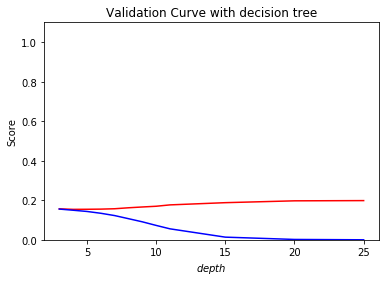

In [13]:
plt.plot(Depths, cv_scores, 'r')
plt.plot(Depths, training_scores, 'b')
plt.title("Validation Curve with decision tree")
plt.xlabel("$depth$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

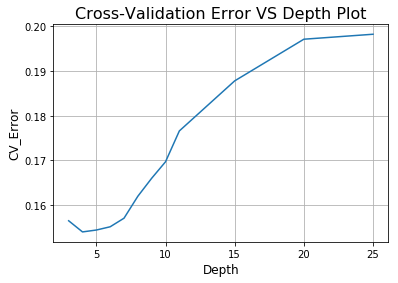

In [14]:
# plotting Cross-Validation Error vs Depth graph 
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Depth Plot',size=16)
plt.grid()
plt.show()

# #Visualize Decision Tree

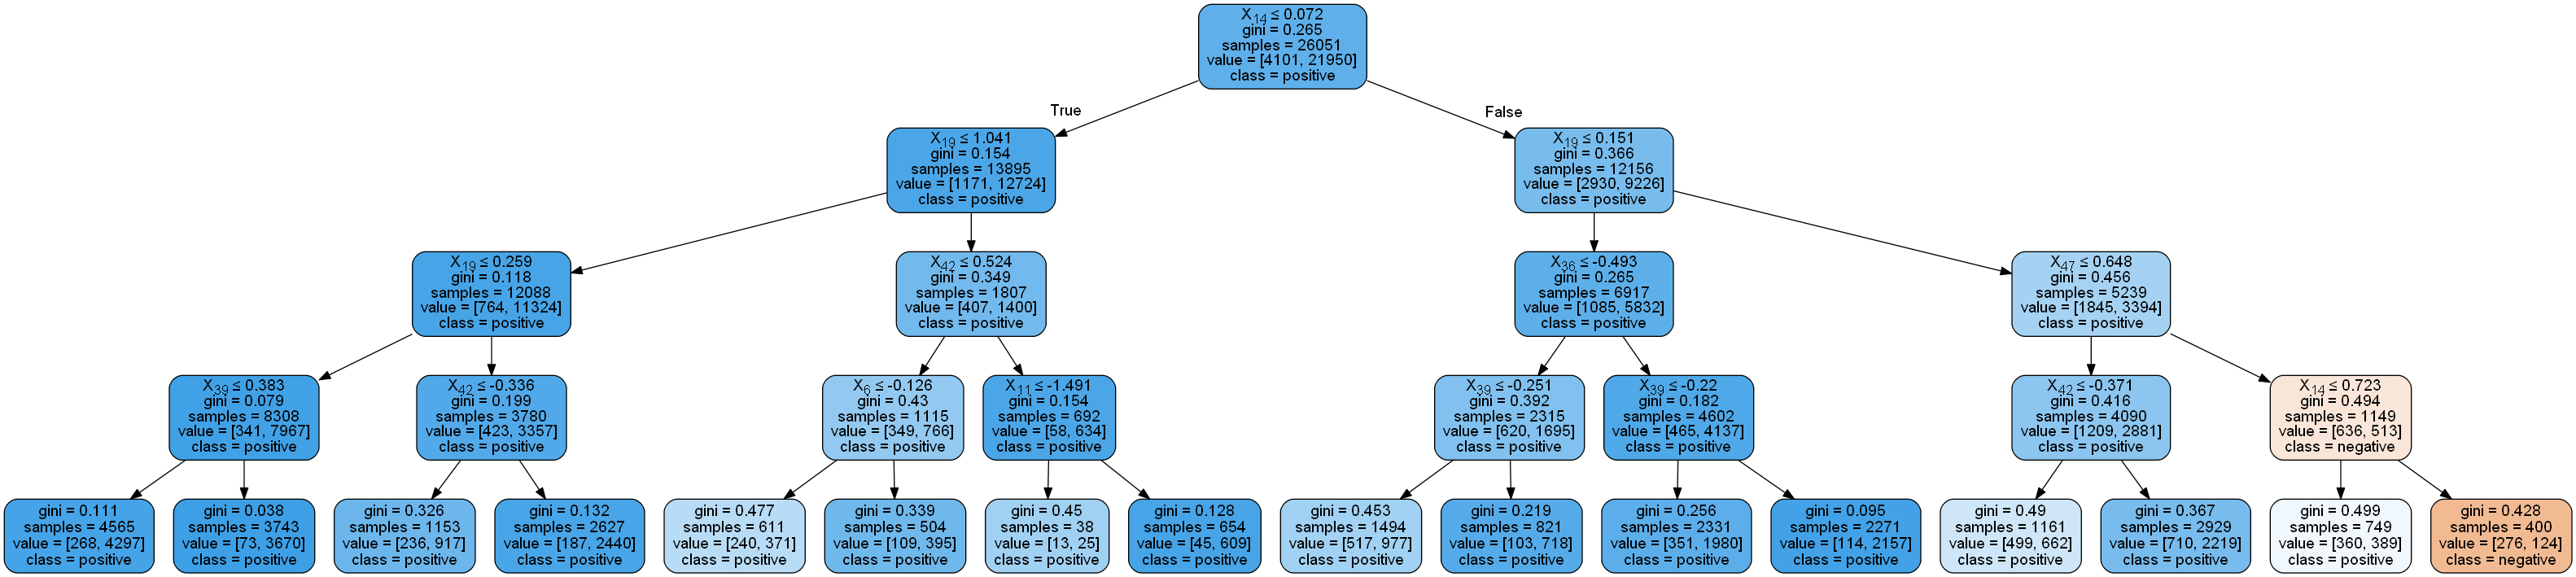

In [15]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)  
#graph = Source(data)

# Show graph
Image(graph.create_png())
#display(SVG(graph.pipe(format='svg')))

Accuracy of the model at optimal hyperparameter depth = 4 is:  85.231954%
Confusion matrix for the model is:


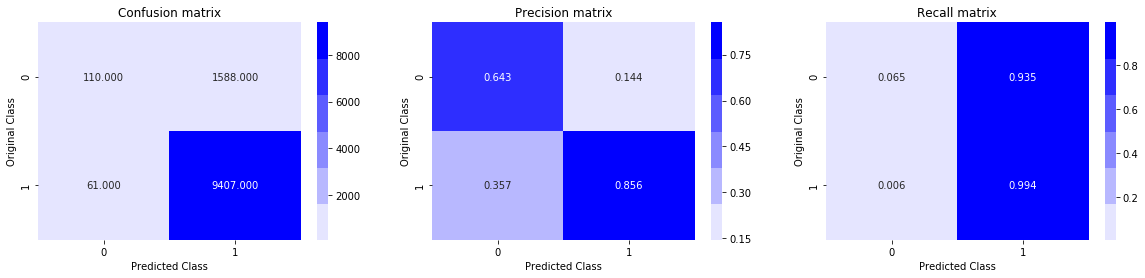

f1 score value for   the model is: 0.8523195414651621
precision score  for   the model is: 0.8555707139608913


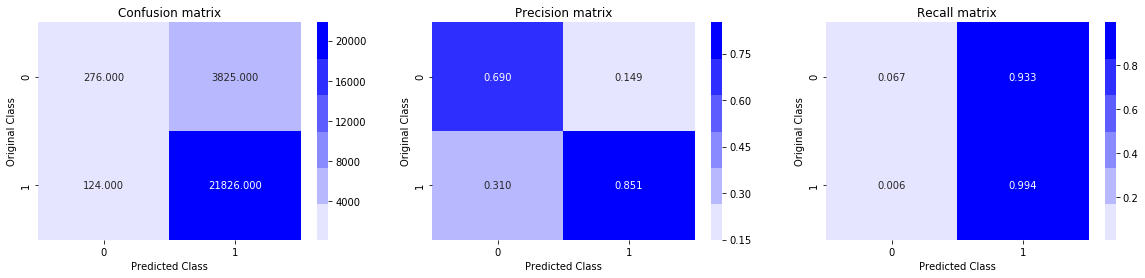

Accuracy of the model at optimal hyperparameter depth = 4 is:  84.841273%
f1 score value for   the model is: 0.8484127288779701
precision score  for   the model is: 0.8508830065104674


In [16]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
Y_pred = dt.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = dt.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)






# Tf-idf word 2 vec

In [17]:
# We will collect different 100K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 
    
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)

(37217, 12)


In [18]:


# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1



In [19]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)

GridSearchCV Implementation (Decision Tree)

In [44]:
Depths = [3,4,5,6,7,8,9,10,11,15,20,25]

param_grid = {'max_depth': Depths}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

# Cross-Validation errors
cv_scores = [1-i for i in model.cv_results_['mean_test_score']]
training_scores=[1-i for i in model.cv_results_['mean_train_score']]

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

# DecisionTreeClassifier with Optimal value of depth
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
predictions = dt.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_depth = optimal_depth
tfidf_w2v_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.784703564391904
The optimal value of depth is :  6


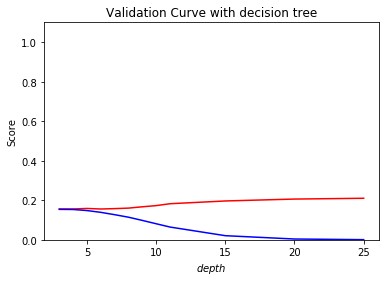

In [45]:
plt.plot(Depths, cv_scores, 'r')
plt.plot(Depths, training_scores, 'b')
plt.title("Validation Curve with decision tree")
plt.xlabel("$depth$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

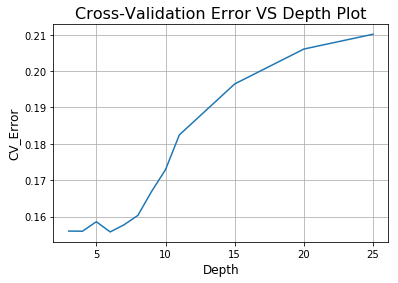

In [46]:
# plotting Cross-Validation Error vs Depth graph 
plt.plot(Depths,  cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Depth Plot',size=16)
plt.grid()
plt.show()

Visualize Decision Tree

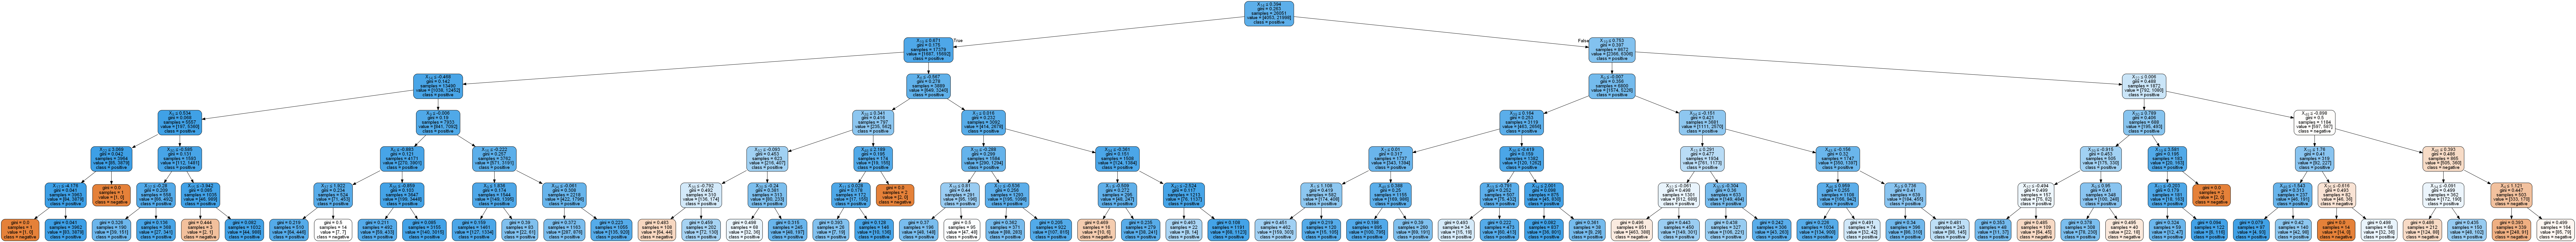

In [47]:
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

Accuracy of the model at optimal hyperparameter depth = 6 is:  78.470356%
Confusion matrix for the model is:


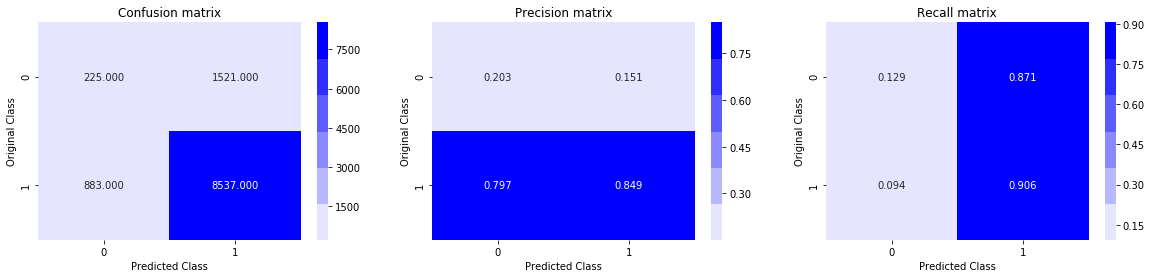

f1 score value for   the model is: 0.784703564391904
precision score  for   the model is: 0.8487770928614039


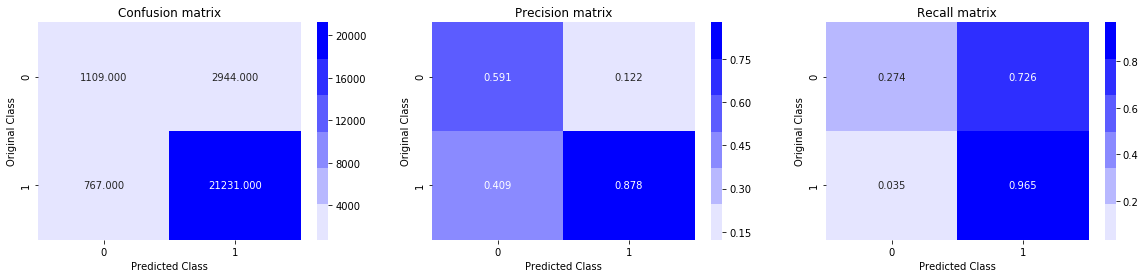

Accuracy of the model at optimal hyperparameter depth = 6 is:  85.754865%
f1 score value for   the model is: 0.8575486545622049
precision score  for   the model is: 0.8782213029989658


In [49]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
Y_pred = dt.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred,average='micro' )
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive', )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = dt.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred,average='micro' )
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive', )
print('precision score  for   the model is: %s'% precisionscore)






Implementing Decision Tree on Small Sample for BoW and TFIDF

In [50]:
# We will collect different 40K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:38000])
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

(37217, 12)


# Bag of Words (BoG)

In [51]:
#BoW
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (26051, 4552)
the number of unique words : 4552


In [52]:
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

## GridSearchCV Implementation (Decision Tree)

In [53]:
Depths = [3,4,5,6,7,8,9,10,11,12,13,15,17,19,20,21,23,25]

param_grid = {'max_depth': Depths}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

# Cross-Validation errors
cv_scores = [1-i for i in model.cv_results_['mean_test_score']]
training_scores=[1-i for i in model.cv_results_['mean_train_score']]

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

# DecisionTreeClassifier with Optimal value of depth
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
predictions = dt.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_depth = optimal_depth
bow_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.8579616693533942
The optimal value of depth is :  8


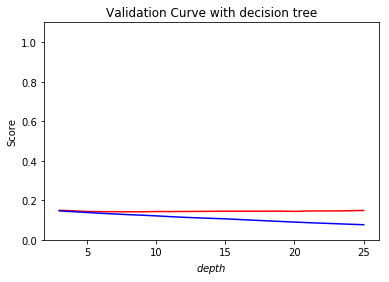

In [54]:
plt.plot(Depths, cv_scores, 'r')
plt.plot(Depths, training_scores, 'b')
plt.title("Validation Curve with decision tree")
plt.xlabel("$depth$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

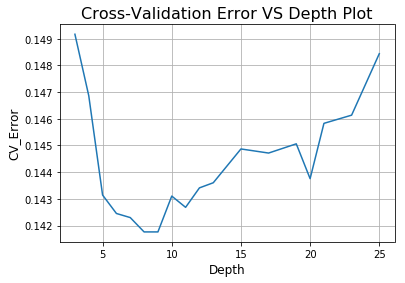

In [55]:
# plotting Cross-Validation Error vs Depth graph 
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Depth Plot',size=16)
plt.grid()
plt.show()

## Visualize Decision Tree

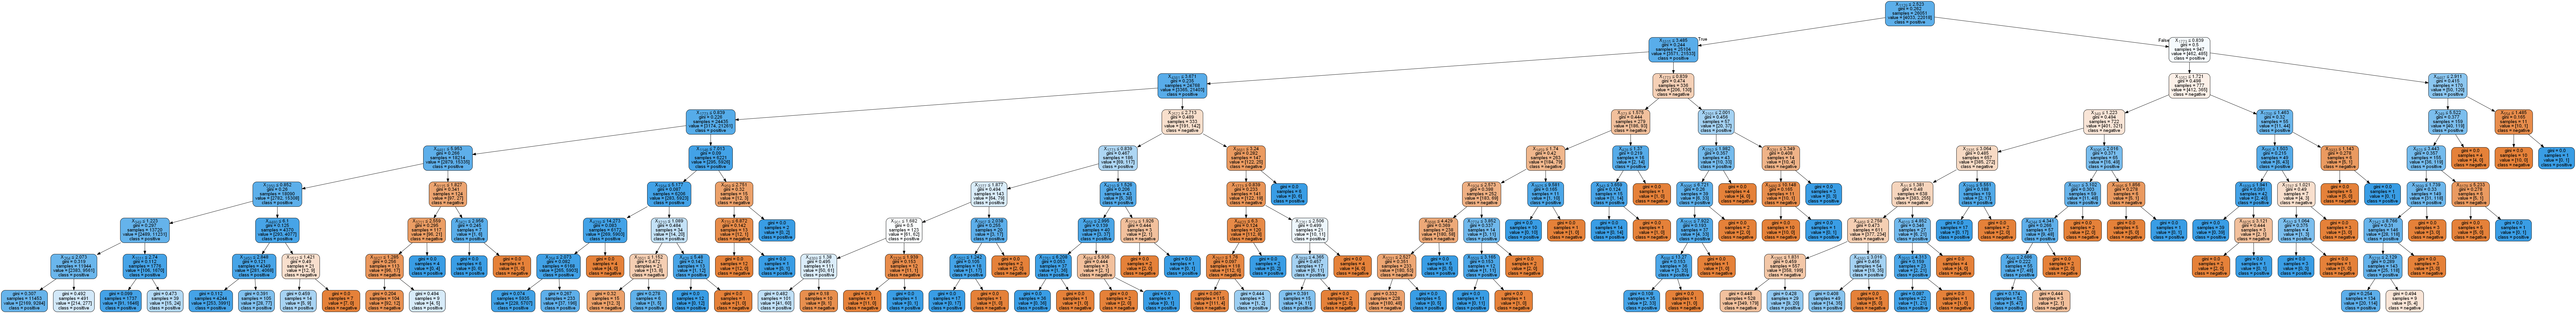

In [56]:
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

Accuracy of the model at optimal hyperparameter depth = 8 is:  85.805123%
Confusion matrix for the model is:


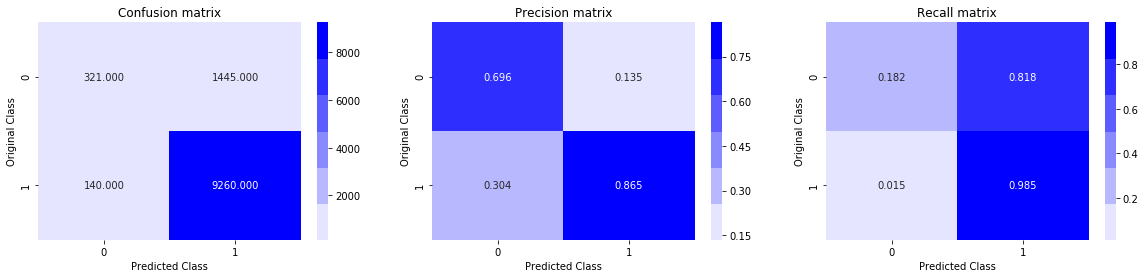

f1 score value for   the model is: 0.8580512269389218
precision score  for   the model is: 0.8650163475011676


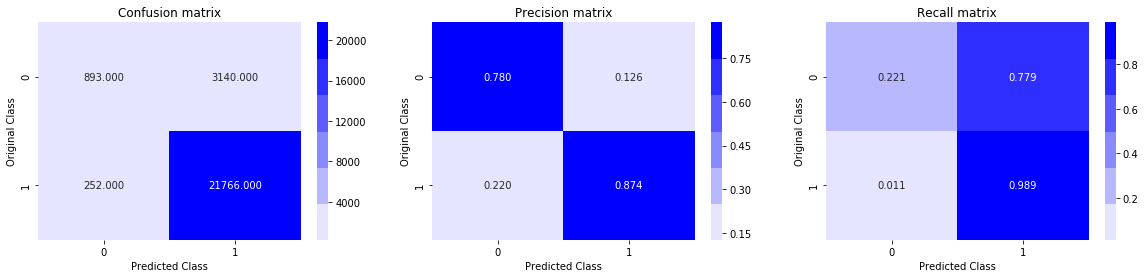

Accuracy of the model at optimal hyperparameter depth = 8 is:  86.979387%
f1 score value for   the model is: 0.8697938658784692
precision score  for   the model is: 0.8739259616156749


In [57]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
Y_pred = dt.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = dt.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# TFIDF

In [58]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (26051, 4552)
the number of unique words : 4552


## GridSearchCV Implementation (Decision Tree)

In [60]:
Depths = [3,4,5,6,7,8,9,10,11,13,15,17,19,20,23,25]

param_grid = {'max_depth': Depths}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

# Cross-Validation errors
cv_scores = [1-i for i in model.cv_results_['mean_test_score']]
training_scores=[1-i for i in model.cv_results_['mean_train_score']]

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

# DecisionTreeClassifier with Optimal value of depth
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
predictions = dt.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_depth = optimal_depth
tfidf_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of the model :  0.855006269030987
The optimal value of depth is :  7


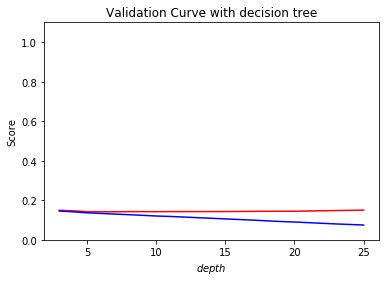

In [61]:
plt.plot(Depths, cv_scores, 'r')
plt.plot(Depths, training_scores, 'b')
plt.title("Validation Curve with decision tree")
plt.xlabel("$depth$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()

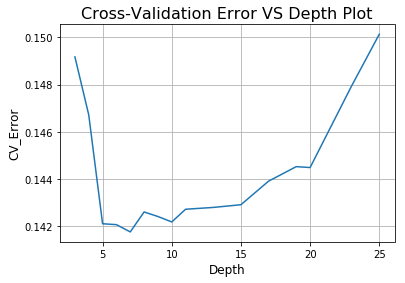

In [62]:
# plotting Cross-Validation Error vs Depth graph 
plt.plot(Depths, cv_scores)
plt.xlabel('Depth',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Depth Plot',size=16)
plt.grid()
plt.show()

Visualize Decision Tree

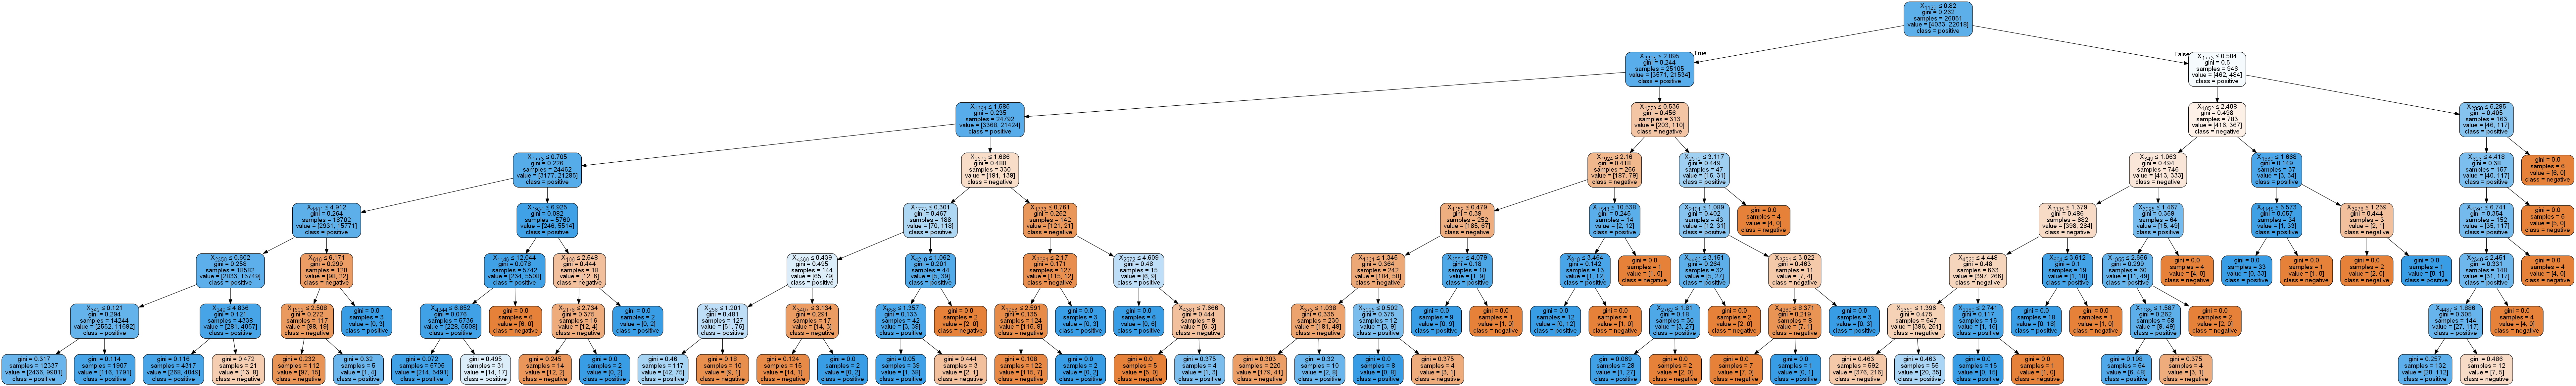

In [63]:
target = ['negative','positive']
# Create DOT data
data = tree.export_graphviz(dt,out_file=None,class_names=target,filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX 

Accuracy of the model at optimal hyperparameter depth = 7 is:  85.599140%
Confusion matrix for the model is:


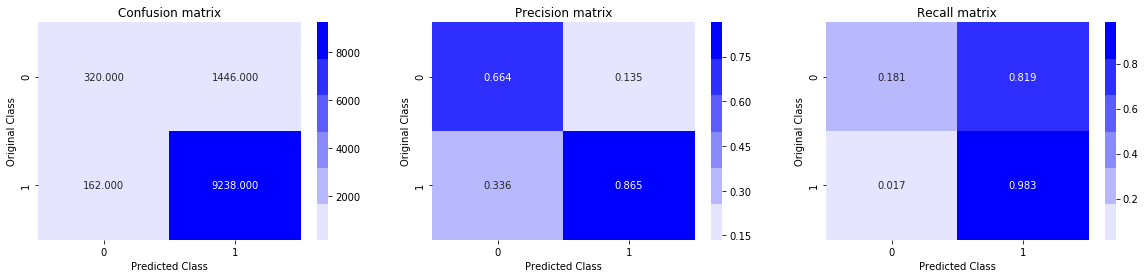

f1 score value for   the model is: 0.8559914024717894
precision score  for   the model is: 0.8646574316735305


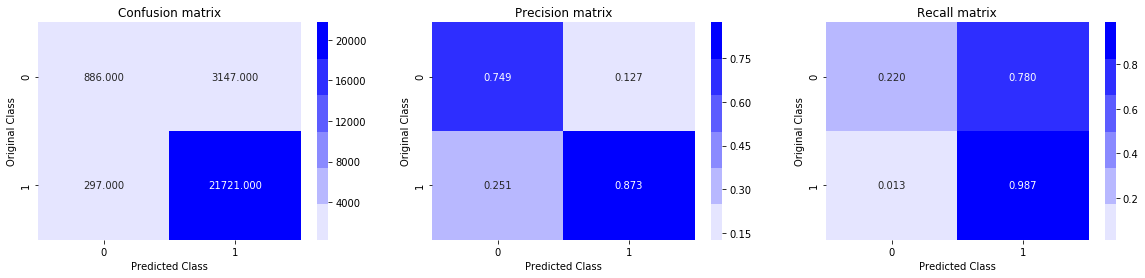

Accuracy of the model at optimal hyperparameter depth = 7 is:  86.779778%
f1 score value for   the model is: 0.867797781275191
precision score  for   the model is: 0.873451825639376


In [64]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(X_train_vec_standardized,Y_train)
Y_pred = dt.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = dt.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_depth,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

In [65]:
from prettytable import PrettyTable

# Names of models
featurization = ['avg word2vec','TFIDF Weighted word2vec','Bag of Words','TFIDF ']

# Training accuracies
F1score= [0.8523,0.7847,0.8580,0.8559]
accuracy = [85.23,78.47,85.80,85.59]
depth=[4,6,8,7]
precision=[0.8555,0.8487,0.8650,0.8646]
numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("alpha",depth)

ptable.add_column("accuracy",accuracy)
ptable.add_column("score",F1score)
ptable.add_column("precision",precision)
# Printing the Table
print(ptable)

+-------+-------------------------+-------+----------+--------+-----------+
| S.NO. |          MODEL          | alpha | accuracy | score  | precision |
+-------+-------------------------+-------+----------+--------+-----------+
|   1   |       avg word2vec      |   4   |  85.23   | 0.8523 |   0.8555  |
|   2   | TFIDF Weighted word2vec |   6   |  78.47   | 0.7847 |   0.8487  |
|   3   |       Bag of Words      |   8   |   85.8   | 0.858  |   0.865   |
|   4   |          TFIDF          |   7   |  85.59   | 0.8559 |   0.8646  |
+-------+-------------------------+-------+----------+--------+-----------+
